In [2]:
import pandas as pd

# 1. Lecture des fichiers CSV
df1 = pd.read_csv('data\\anciennete&size.csv')
df2 = pd.read_csv('data\Colab_data.xlsx - Sheet1.csv', usecols=['idstd','colab'])
df3 = pd.read_csv('data\\inno&secteur.csv', usecols=['idstd','Innovation', 'Secteur_Service', 'Secteur_Production'])

df5 = pd.read_csv('data\IT_data.xlsx - Sheet 1.csv', usecols=['idstd','IT'])
df6 =  pd.read_csv('data\R&D_data.xlsx - Sheet1.csv',usecols=['idstd','R&D', 'Country'])

# 2. Fusion itérative sur la colonne commune 'idstd'
df_merged = df1.merge(df2, on='idstd', how='outer')
df_merged = df_merged.merge(df3, on='idstd', how='outer')
df_merged = df_merged.merge(df5, on='idstd', how='outer')
df_merged = df_merged.merge(df6, on='idstd', how='outer')

In [3]:

# 1. Convertir la colonne en type 'category'
df_merged['Country'] = df_merged['Country'].astype('category')

# 2. Réordonner les catégories pour mettre 'IN' en premier
current_categories = df_merged['Country'].cat.categories.tolist()
if 'IN' in current_categories:
    # Retire 'IN' de la liste
    current_categories.remove('IN')
    # Ajoute 'IN' en première position
    new_order = ['IN'] + current_categories
    # Réordonne
    df_merged['Country'] = df_merged['Country'].cat.reorder_categories(new_order, ordered=False)
else:
    print("Attention, la valeur 'IN' n'existe pas dans la colonne 'country'.")

# 3. Créer les variables binaires en supprimant la première catégorie (ici 'IN')
df_merged = pd.get_dummies(
    df_merged, 
    columns=['Country'], 
    drop_first=True  # va « drop » la première catégorie, donc 'IN'
)



In [4]:
na_count = df_merged.isna().sum()

print(na_count)


idstd                    0
Ancienneté             138
size_Large               0
size_Medium              0
size_Small               0
colab                 1858
Innovation               1
Secteur_Service          0
Secteur_Production       0
IT                      50
R&D                      8
Country_BA               0
Country_NE               0
Country_PA               0
dtype: int64


In [5]:
df_merged.dropna(inplace=True)
df_merged.describe()


,idstd,Ancienneté,size_Large,size_Medium,size_Small,colab,Innovation,Secteur_Service,Secteur_Production,IT,R&D
count,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000
mean,559510.082092,19.829856,0.370089,0.572745,0.057166,0.216473,0.975075,0.181523,0.171769,0.263614,0.810620
std,16631.398293,14.259340,0.482894,0.494747,0.232191,0.411896,0.155919,0.385503,0.377231,0.440652,0.391863
min,527763.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,562395.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,565995.000000,16.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,569425.000000,26.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,582136.000000,123.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_merged = df_merged.replace({
    True:1,
    False:0
})

C:\Users\zoero\AppData\Local\Temp\ipykernel_13596\4100541384.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged = df_merged.replace({


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_merged['Ancienneté'] = scaler.fit_transform(df_merged[['Ancienneté']])
print(df_merged.dtypes)

df_merged.to_csv('final_data_inno_bin.csv')

idstd                   int64
Ancienneté            float64
size_Large              int64
size_Medium             int64
size_Small              int64
colab                 float64
Innovation            float64
Secteur_Service         int64
Secteur_Production      int64
IT                    float64
R&D                   float64
Country_BA              int64
Country_NE              int64
Country_PA              int64
dtype: object


In [8]:
df_merged.drop(columns=['idstd'], inplace=True)

Normaliser data continues

Corrélation

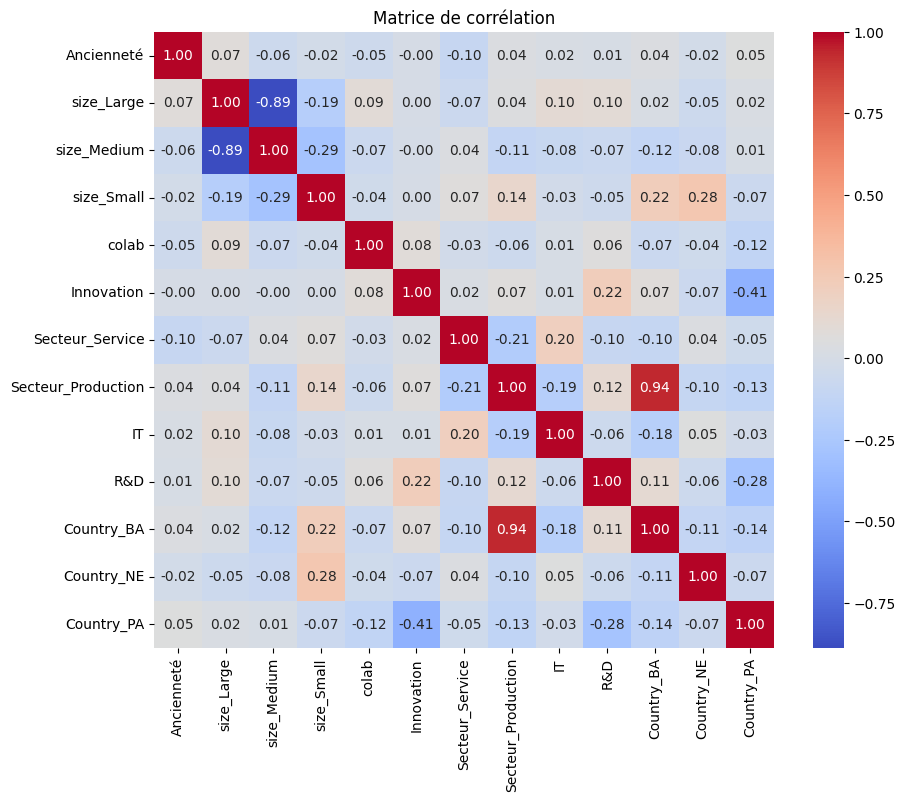

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_merged.corr(numeric_only=True)

# 2. Création et affichage de la heatmap
plt.figure(figsize=(10, 8))  # Ajustez la taille si nécessaire
sns.heatmap(corr,
            annot=True,     # Affiche les coefficients sur la heatmap
            cmap='coolwarm',
            fmt='.2f')      # Format des nombres
plt.title('Matrice de corrélation')
plt.show()

ajout des variables 

In [10]:
import statsmodels.api as sm
from statsmodels.tools import add_constant


data = df_merged.copy()


# Créer les termes d'interaction
data['colab_IT'] = data['colab'] * data['IT']
data['colab_RD'] = data['colab'] * data['R&D']
data['IT_RD'] = data['IT'] * data['R&D']
data['colab_IT_RD'] = data['colab'] * data['IT'] * data['R&D']

# Définir les variables explicatives principales, interactions, et variables de contrôle
variables_explicatives = ['colab', 'IT', 'R&D', 'colab_IT', 'colab_RD', 'IT_RD', 'colab_IT_RD']
variables_controle = ['size_Medium', 'size_Large', 'size_Small', 'Ancienneté','Country_BA', 'Country_NE', 'Country_PA', 'Secteur_Service','Secteur_Production']

# Créer le DataFrame final des variables
X = data[variables_explicatives + variables_controle]
y = data['Innovation']  # Variable cible (booléenne)

# Ajouter une constante pour le modèle
X = add_constant(X)

Multi colinéarité

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculer le VIF pour chaque variable explicative
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)



              Variable        VIF
0                const   0.000000
1                colab   9.516288
2                   IT   5.844988
3                  R&D   1.956113
4             colab_IT  10.393998
5             colab_RD   9.803212
6                IT_RD   6.209853
7          colab_IT_RD  10.623235
8          size_Medium        inf
9           size_Large        inf
10          size_Small        inf
11          Ancienneté   1.023260
12          Country_BA   9.738431
13          Country_NE   1.128935
14          Country_PA   1.172435
15     Secteur_Service   1.228452
16  Secteur_Production   9.633459


c:\Users\zoero\OneDrive\Bureau\M2\S1\innovation\projet\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\zoero\OneDrive\Bureau\M2\S1\innovation\projet\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Multi colinéarité + déséquilibre de la variable cible -> regression logit avec penalité Lasso et poids

Logit avec poids 

In [18]:
from sklearn.linear_model import LogisticRegression


# Ajuster un modèle logistique avec Lasso
model = LogisticRegression(
    penalty='l1',            # Pénalité L1 (Lasso)
    solver='liblinear',      # Solver compatible avec L1
    C=1.0,                   # Force de la régularisation
    class_weight=class_weight={0: 20, 1: 1}   # Poids des classes
)
model.fit(X, y)

# Résumé des coefficients
coefficients = pd.DataFrame({
    'Variable': ['Intercept'] + list(X.columns),
    'Coefficient': [model.intercept_[0]] + list(model.coef_[0])
})
print(coefficients)

# Obtenir les prédictions et leur probabilité
y_pred = model.predict(X)
y_pred_prob = model.predict_proba(X)[:, 1]

# Calculer des métriques supplémentaires
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))


              Variable  Coefficient
0            Intercept     0.440453
1                const     0.339739
2                colab     5.114065
3                   IT     0.448148
4                  R&D     1.387399
5             colab_IT     0.000000
6             colab_RD     0.000000
7                IT_RD    -0.932752
8          colab_IT_RD     0.000000
9          size_Medium     0.000000
10          size_Large     0.076493
11          size_Small     0.434211
12          Ancienneté     0.060742
13          Country_BA     0.758855
14          Country_NE    -2.997877
15          Country_PA    -4.010246
16     Secteur_Service     0.558761
17  Secteur_Production     0.000000
              precision    recall  f1-score   support

         0.0       0.19      0.91      0.32        92
         1.0       1.00      0.90      0.95      3599

    accuracy                           0.90      3691
   macro avg       0.59      0.91      0.63      3691
weighted avg       0.98      0.90      0.93 

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight={0: 20, 1: 1}, random_state=42)
rf_model.fit(X, y)

# Evaluate
y_pred_rf = rf_model.predict(X)
print(classification_report(y, y_pred_rf))


              precision    recall  f1-score   support

         0.0       0.60      0.98      0.74        92
         1.0       1.00      0.98      0.99      3599

    accuracy                           0.98      3691
   macro avg       0.80      0.98      0.87      3691
weighted avg       0.99      0.98      0.98      3691



In [24]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

               Feature  Importance
14          Country_PA    0.367102
11          Ancienneté    0.236353
3                  R&D    0.147878
13          Country_NE    0.068584
1                colab    0.042401
15     Secteur_Service    0.022586
12          Country_BA    0.018290
16  Secteur_Production    0.017996
6                IT_RD    0.017251
2                   IT    0.016106
5             colab_RD    0.014507
8          size_Medium    0.011017
9           size_Large    0.010613
10          size_Small    0.007232
4             colab_IT    0.001735
7          colab_IT_RD    0.000352
0                const    0.000000
